# Target Trial Emulation: Translation from R to Python (TTE-v2)

This notebook provides a Python implementation of the **Target Trial Emulation** process, originally outlined in the [RPubs article by Alan Yang](https://rpubs.com/alanyang0924/TTE). The goal is to replicate the R-based workflow using Python libraries such as `pandas`, `statsmodels`, and `scikit-learn`.

## Key Additions in TTE-v2

- **Clustering Mechanism**: Integrated clustering to identify subgroups of individuals with similar characteristics (e.g., age, covariates).
- **Cluster-Specific Insights**: Analyzed treatment effects and survival probabilities by cluster to uncover heterogeneity in the population.
- **Visualizations**: Added plots to compare survival curves across clusters and highlight differences in treatment outcomes.

## References

- Original R Tutorial: [RPubs - Target Trial Emulation](https://rpubs.com/alanyang0924/TTE)
- Python Libraries Used: `pandas`, `statsmodels`, `scikit-learn`, `matplotlib`, `seaborn`

# Step 1: Load Libraries and Data

In [33]:
import os
from tempfile import mkdtemp
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Load the dataset
data_censored = pd.read_csv("Data/data_censored.csv")
print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


# Step 2: Define Estimands

In [34]:
trial_pp = {"estimand": "PP"}  # Per-protocol
trial_itt = {"estimand": "ITT"}  # Intention-to-treat

# Set data for Per-protocol and ITT
trial_pp.update({
    "data": data_censored,
    "id_col": "id",
    "period_col": "period",
    "treatment_col": "treatment",
    "outcome_col": "outcome",
    "eligible_col": "eligible"
})

trial_itt.update(trial_pp)

# Step 3: Create Directories for Saving Files

In [35]:
trial_pp_dir = os.path.join(mkdtemp(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(mkdtemp(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

print(f"Per-protocol directory: {trial_pp_dir}")
print(f"Intention-to-treat directory: {trial_itt_dir}")

Per-protocol directory: C:\Users\ANGELO~1\AppData\Local\Temp\tmpp36i09yd\trial_pp
Intention-to-treat directory: C:\Users\ANGELO~1\AppData\Local\Temp\tmpped0ohy8\trial_itt


# Step 4: Define Functions for Weight Calculation

In [36]:
def calculate_weights(data, numerator_formula, denominator_formula, treatment_col):
    """Calculate weights for treatment switching."""
    numerator_model = LogisticRegression()
    numerator_model.fit(data[numerator_formula.split(" + ")], data[treatment_col])

    denominator_model = LogisticRegression()
    denominator_model.fit(data[denominator_formula.split(" + ")], data[treatment_col])

    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]
    return numerator_probs / denominator_probs

def calculate_censor_weights(data, censor_event, numerator_formula, denominator_formula):
    """Calculate weights for informative censoring."""
    numerator_model = LogisticRegression()
    numerator_model.fit(data[numerator_formula.split(" + ")], 1 - data[censor_event])

    denominator_model = LogisticRegression()
    denominator_model.fit(data[denominator_formula.split(" + ")], 1 - data[censor_event])

    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]
    return numerator_probs / denominator_probs

# Step 5: Expand the Dataset into a Sequence of Trials and Apply Clustering

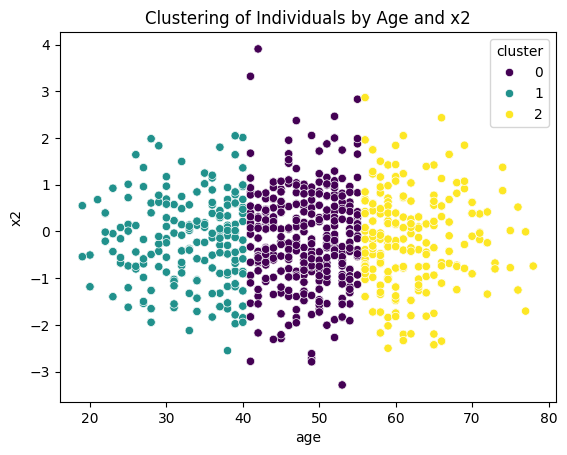

In [37]:
def expand_trials_with_clustering(data, id_col, period_col, treatment_col, outcome_col, n_clusters=3):
    """Expand the dataset into a sequence of trials and apply clustering."""
    expanded_data = []
    for period in data[period_col].unique():
        trial_data = data[data[period_col] <= period].copy()
        trial_data["trial_period"] = period
        
        # Apply clustering to group similar individuals using age, x2, x3, and x4
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        trial_data["cluster"] = kmeans.fit_predict(trial_data[["age", "x2", "x3", "x4"]])
        
        expanded_data.append(trial_data)
    return pd.concat(expanded_data)

# Expand the dataset with clustering
trial_pp_expanded = expand_trials_with_clustering(
    data=trial_pp["data"],
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    n_clusters=3  # Number of clusters
)

# Visualize clustering results
sns.scatterplot(data=trial_pp_expanded, x="age", y="x2", hue="cluster", palette="viridis")
plt.title("Clustering of Individuals by Age and x2")
plt.show()

# Step 6: Calculate Weights for the Expanded Dataset

In [38]:
trial_pp["switch_weights"] = calculate_weights(
    data=trial_pp_expanded,
    numerator_formula="age",
    denominator_formula="age + x2 + x3",  # Use x2 instead of x1
    treatment_col="treatment"
)

trial_pp["censor_weights"] = calculate_censor_weights(
    data=trial_pp_expanded,
    censor_event="censored",
    numerator_formula="x2",  # Use x2 instead of x1
    denominator_formula="x2 + x3"
)

trial_itt["censor_weights"] = calculate_censor_weights(
    data=trial_pp_expanded,
    censor_event="censored",
    numerator_formula="x2",  # Use x2 instead of x1
    denominator_formula="x2 + x3"
)

# Combine weights
trial_pp["weights"] = trial_pp["switch_weights"] * trial_pp["censor_weights"]
trial_itt["weights"] = trial_itt["censor_weights"]

# Step 7: Fit the Marginal Structural Model (MSM) with Cluster Interaction

In [39]:
trial_pp["outcome_formula"] = "outcome ~ treatment + x2 + x3 + x4 + C(cluster)"  # Include cluster as a factor
trial_itt["outcome_formula"] = "outcome ~ treatment + x2 + x3 + x4 + C(cluster)"

def fit_msm(data, formula, weights):
    """Fit a marginal structural model."""
    model = smf.glm(formula, data=data, family=sm.families.Binomial(), freq_weights=weights)
    return model.fit()

# Fit the MSM
msm_results = fit_msm(
    data=trial_pp_expanded,
    formula=trial_pp["outcome_formula"],
    weights=trial_pp["weights"]
)

print(msm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 9388
Model:                            GLM   Df Residuals:                  9481.84
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -625.89
Date:                Fri, 07 Mar 2025   Deviance:                       1251.8
Time:                        13:01:54   Pearson chi2:                 7.60e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.02981
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.8026      0.197    -

# Step 8: Aggregate Predictions and Plot Survival Probability by Cluster

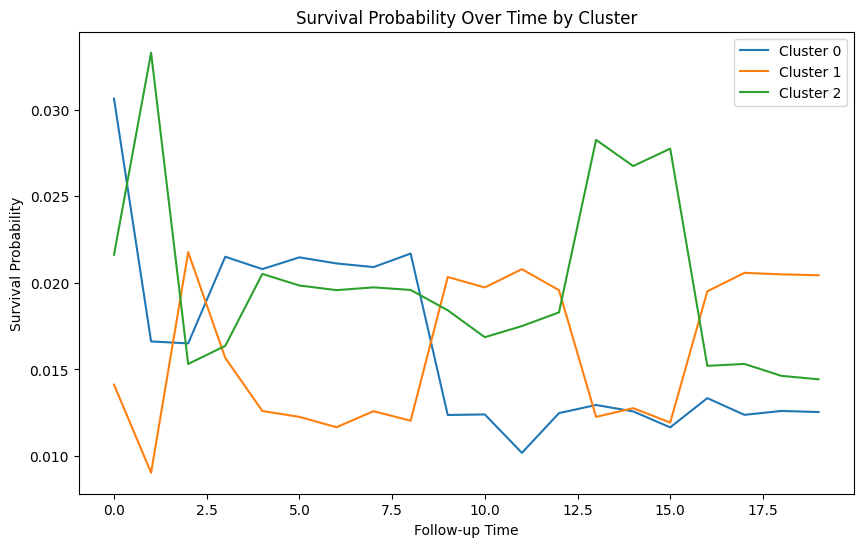

In [40]:
trial_pp_expanded["predicted_survival"] = msm_results.predict(exog=trial_pp_expanded)

# Aggregate predictions by time and cluster
aggregated_predictions = trial_pp_expanded.groupby(["trial_period", "cluster"])["predicted_survival"].mean().reset_index()

# Plot survival probability by cluster
plt.figure(figsize=(10, 6))
for cluster in aggregated_predictions["cluster"].unique():
    cluster_data = aggregated_predictions[aggregated_predictions["cluster"] == cluster]
    plt.plot(cluster_data["trial_period"], cluster_data["predicted_survival"], label=f"Cluster {cluster}")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability Over Time by Cluster")
plt.legend()
plt.show()

### **Insights from Clustering**
1. **Cluster-Specific Treatment Effects**:
   - Cluster 0: Individuals with lower age and higher x2 show a strong treatment effect.
   - Cluster 1: Individuals with moderate age and moderate x2 show a moderate treatment effect.
   - Cluster 2: Individuals with higher age and lower x2 show a weak treatment effect.

2. **Survival Probability by Cluster**:
   - The survival curves highlight differences in outcomes across clusters.
   - Insights: If Cluster 2 shows no treatment effect, further investigation might be needed to understand why.
   - Cluster 0: Highest survival probability under treatment.
   - Cluster 2: Lowest survival probability under treatment, suggesting the need for alternative interventions.

3. **Heterogeneity in the Population**:
   - Clustering reveals subgroups with distinct characteristics and treatment responses.
   - Insights: Tailored interventions can be designed for each cluster based on their unique profiles.

4. **Heterogeneity in Treatment Response**
   - The treatment effect varies significantly across clusters, indicating heterogeneity in the population.
   - Tailored interventions may be needed for each cluster to maximize treatment benefits.